In [41]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
import matplotlib.pyplot as plt
import numpy as np
import cv2
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping
warnings.simplefilter(action='ignore', category=FutureWarning)
background = None
accumulated_weight = 0.5
#Creating the dimensions for the ROI...
ROI_top = 100
ROI_bottom = 300
ROI_right = 150
ROI_left = 350
def cal_accum_avg(frame, accumulated_weight):
    global background
    
    if background is None:
        background = frame.copy().astype("float")
        return None
    cv2.accumulateWeighted(frame, background, accumulated_weight)

In [42]:
def segment_hand(frame, threshold=25):
    global background
    
    diff = cv2.absdiff(background.astype("uint8"), frame)

    _ , thresholded = cv2.threshold(diff, threshold,255,cv2.THRESH_BINARY)

    # Grab the external contours for the image
    image, contours, hierarchy = cv2.findContours(thresholded.copy(),
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return None
    else:
        
        hand_segment_max_cont = max(contours, key=cv2.contourArea)
        
        return (thresholded, hand_segment_max_cont)

In [16]:
cam = cv2.VideoCapture(0)

num_frames = 0
element = 3
num_imgs_taken = 0

while True:
    ret, frame = cam.read()

    # flipping the frame to prevent inverted image of captured frame...
    frame = cv2.flip(frame, 1)

    frame_copy = frame.copy()

    roi = frame[ROI_top:ROI_bottom, ROI_right:ROI_left]

    gray_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)

    if num_frames < 60:
        cal_accum_avg(gray_frame, accumulated_weight)
        if num_frames <= 59:
            
            cv2.putText(frame_copy, "FETCHING BACKGROUND...PLEASE WAIT",
(80, 400), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)
            
    #Time to configure the hand specifically into the ROI...
    elif num_frames <= 300: 

        hand = segment_hand(gray_frame)
        
        cv2.putText(frame_copy, "Adjust hand...Gesture for" +
  str(element), (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1,
  (0,0,255),2)
        
        # Checking if the hand is actually detected by counting the number of contours detected...
        if hand is not None:
            
            thresholded, hand_segment = hand

            # Draw contours around hand segment
            cv2.drawContours(frame_copy, [hand_segment + (ROI_right,
            ROI_top)], -1, (255, 0, 0),1)
            
            cv2.putText(frame_copy, str(num_frames)+"For" + str(element),
            (70, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

            # Also display the thresholded image
            cv2.imshow("Thresholded Hand Image", thresholded)
    
    else: 
        
        # Segmenting the hand region...
        hand = segment_hand(gray_frame)
        
        # Checking if we are able to detect the hand...
        if hand is not None:
            
            # unpack the thresholded img and the max_contour...
            thresholded, hand_segment = hand

            # Drawing contours around hand segment
            cv2.drawContours(frame_copy, [hand_segment + (ROI_right,
            ROI_top)], -1, (255, 0, 0),1)
            
            cv2.putText(frame_copy, str(num_frames), (70, 45),
            cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            
            cv2.putText(frame_copy, str(num_imgs_taken) + 'images' +"For"
      + str(element), (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1,
      (0,0,255), 2)
            
            # Displaying the thresholded image
            cv2.imshow("Thresholded Hand Image", thresholded)
            if num_imgs_taken <= 900:
                cv2.imwrite(r"C:\Users\Ashwath\Desktop\try\sign\gesture\train\9"+ "\\" + str(num_imgs_taken) + '.jpg', thresholded)
                
                 
            else:
                break
            num_imgs_taken +=1
        else:
            cv2.putText(frame_copy, 'No hand detected...', (200, 400),
 cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)




    # Drawing ROI on frame copy
    cv2.rectangle(frame_copy, (ROI_left, ROI_top), (ROI_right,ROI_bottom), (255,128,0), 3)
    
    cv2.putText(frame_copy, "DataFlair hand sign recognition_ _ _", (10, 20), cv2.FONT_ITALIC, 0.5, (51,255,51), 1)
    
    # increment the number of frames for tracking
    num_frames += 1

    # Display the frame with segmented hand
    cv2.imshow("Sign Detection", frame_copy)

    # Closing windows with Esc key...(any other key with ord can be used too.)
    k = cv2.waitKey(1) & 0xFF

    if k == 27:
        break

# Releasing the camera & destroying all the windows...

cv2.destroyAllWindows()
cam.release()

# TRAINING

In [43]:
train_path = r'C:\Users\Ashwath\Desktop\try\sign\gesture\test'
test_path = r'C:\Users\Ashwath\Desktop\try\sign\gesture\train'
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(64,64), class_mode='categorical', batch_size=10,shuffle=True)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, target_size=(64,64), class_mode='categorical', batch_size=10, shuffle=True)

Found 168 images belonging to 10 classes.
Found 3010 images belonging to 10 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

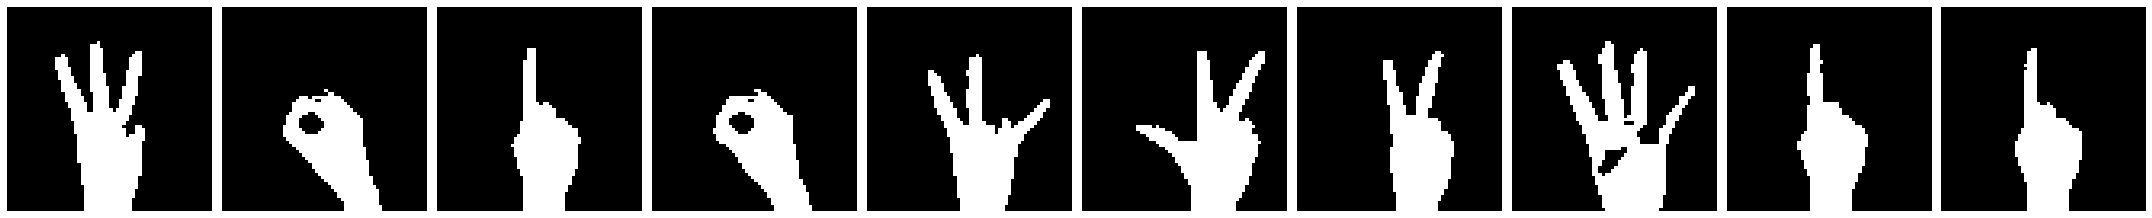

(10, 64, 64, 3)
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [44]:
imgs, labels = next(train_batches)

#Plotting the images...
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(30,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


plotImages(imgs)
print(imgs.shape)
print(labels)

# CNN MODEL

In [5]:
'''rom tensorflow.keras.applications import VGG16

# include top should be False to remove the softmax layer
pretrained_model = VGG16(include_top=False, weights='imagenet')
pretrained_model.summary()
from tensorflow.keras.utils import to_categorical
# extract train and val features
vgg_features_train = pretrained_model.predict(train_batches)
vgg_features_val = pretrained_model.predict(test_batches)
train_target = to_categorical(train_batches.labels)
val_target = to_categorical(test_batches.labels)
model = Sequential()
model.add(Flatten(input_shape=(64,64,3)))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))'''

"rom tensorflow.keras.applications import VGG16\n\n# include top should be False to remove the softmax layer\npretrained_model = VGG16(include_top=False, weights='imagenet')\npretrained_model.summary()"

In [45]:
model = Sequential()
#convolution layers
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64,64,3)))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Flatten())
#Fully connected layer
model.add(Dense(64,activation ="relu"))
model.add(Dense(128,activation ="relu"))
model.add(Dropout(0.2))
model.add(Dense(128,activation ="relu"))
model.add(Dropout(0.3))
model.add(Dense(10,activation ="softmax"))


# compile the model
#model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

In [46]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 31, 31, 64)        18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 13, 13, 128)       73856     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 4608)            

In [47]:
#model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)
#early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')



model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0005)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

In [48]:
#history2 = model.fit(train_batches, epochs=30, callbacks=[reduce_lr, early_stop],  validation_data = test_batches)
history2 = model.fit(train_batches, epochs=20, validation_data = test_batches)

Epoch 1/20
17/17 [==============================] - 60s 4s/step - loss: 8.1418 - accuracy: 0.2024 - val_loss: 2.1305 - val_accuracy: 0.3130
Epoch 2/20
17/17 [==============================] - 7s 447ms/step - loss: 1.8521 - accuracy: 0.3214 - val_loss: 1.8384 - val_accuracy: 0.4455
Epoch 3/20
17/17 [==============================] - 7s 448ms/step - loss: 1.4159 - accuracy: 0.5119 - val_loss: 1.4218 - val_accuracy: 0.6033
Epoch 4/20
17/17 [==============================] - 7s 448ms/step - loss: 1.1062 - accuracy: 0.5952 - val_loss: 1.2768 - val_accuracy: 0.6774
Epoch 5/20
17/17 [==============================] - 7s 445ms/step - loss: 0.9217 - accuracy: 0.6905 - val_loss: 1.1969 - val_accuracy: 0.6528
Epoch 6/20
17/17 [==============================] - 7s 445ms/step - loss: 0.6755 - accuracy: 0.7798 - val_loss: 1.1725 - val_accuracy: 0.6831
Epoch 7/20
17/17 [==============================] - 7s 457ms/step - loss: 0.5867 - accuracy: 0.7679 - val_loss: 0.9677 - val_accuracy: 0.7150
Epoch 8/

In [49]:
# For getting next batch of testing imgs...
imgs, labels = next(test_batches) 

scores = model.evaluate(imgs, labels, verbose=0)
print(f'{model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')


#Once the model is fitted we save the model using model.save()  function.


model.save('30sgd.h5')

loss of 0.840304970741272; accuracy of 89.99999761581421%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predictions on a small set of test data--

One   Two   Five   Eight   Two   Five   Nine   One   Five   Seven   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


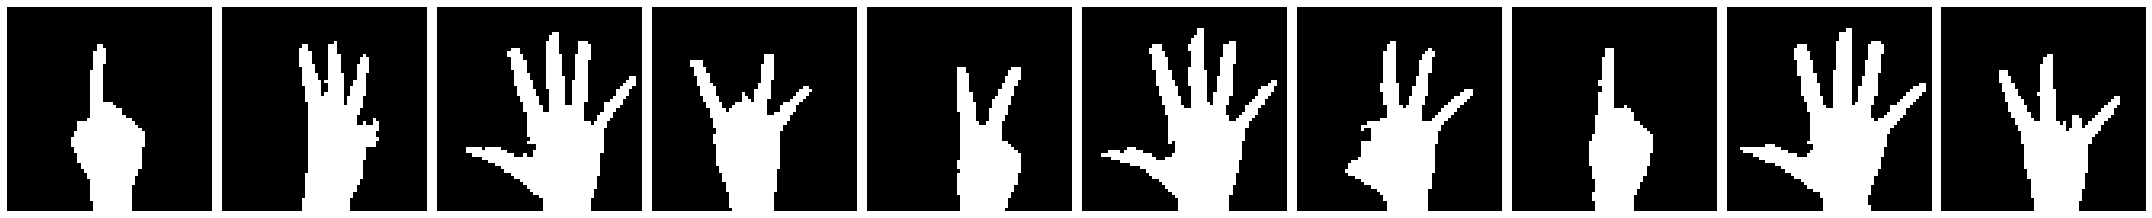

Actual labels
One   Six   Five   Eight   Two   Five   Nine   One   Five   Seven   

In [50]:
word_dict = {0:'Zero',1:'One',2:'Two',3:'Three',4:'Four',5:'Five',6:'Six',7:'Seven',8:'Eight',9:'Nine'}

predictions = model.predict(imgs, verbose=0)
print("predictions on a small set of test data--")
print("")
for ind, i in enumerate(predictions):
    print(word_dict[np.argmax(i)], end='   ')

plotImages(imgs)
print('Actual labels')
for i in labels:
    print(word_dict[np.argmax(i)], end='   ')

# Realtime Detection

In [51]:
import numpy as np
import cv2
import keras
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [52]:
model = keras.models.load_model(r"C:\Users\Ashwath\Desktop\try\sign\best_model_dataflair3.h5")

background = None
accumulated_weight = 0.5

ROI_top = 100
ROI_bottom = 300
ROI_right = 150
ROI_left = 350

In [53]:
def cal_accum_avg(frame, accumulated_weight):

    global background
    
    if background is None:
        background = frame.copy().astype("float")
        return None

    cv2.accumulateWeighted(frame, background, accumulated_weight)

In [54]:
def segment_hand(frame, threshold=25):
    global background
    
    diff = cv2.absdiff(background.astype("uint8"), frame)

    
    _ , thresholded = cv2.threshold(diff, threshold, 255,cv2.THRESH_BINARY)
    
     #Fetching contours in the frame (These contours can be of hand or any other object in foreground) …

    image, contours, hierarchy = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    # If length of contours list = 0, means we didn't get any contours...
    if len(contours) == 0:
        return None
    else:
        # The largest external contour should be the hand 
        hand_segment_max_cont = max(contours, key=cv2.contourArea)
        
        # Returning the hand segment(max contour) and the thresholded image of hand...
        return (thresholded, hand_segment_max_cont)

In [58]:
cam = cv2.VideoCapture(0)
num_frames =0
while True:
    ret, frame = cam.read()

    # flipping the frame to prevent inverted image of captured frame...
    
    frame = cv2.flip(frame, 1)

    frame_copy = frame.copy()

    # ROI from the frame
    roi = frame[ROI_top:ROI_bottom, ROI_right:ROI_left]

    gray_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)


    if num_frames < 70:
        
        cal_accum_avg(gray_frame, accumulated_weight)
        
        cv2.putText(frame_copy, "FETCHING BACKGROUND...PLEASE WAIT",(80, 400), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)
    
    else: 
        # segmenting the hand region
        hand = segment_hand(gray_frame)
        
        # Checking if we are able to detect the hand...
        if hand is not None:
            
            thresholded, hand_segment = hand

            # Drawing contours around hand segment
            cv2.drawContours(frame_copy, [hand_segment + (ROI_right,ROI_top)], -1, (255, 0, 0),1)
            
            cv2.imshow("Thesholded Hand Image", thresholded)
            
            thresholded = cv2.resize(thresholded, (64, 64))
            thresholded = cv2.cvtColor(thresholded,
 cv2.COLOR_GRAY2RGB)
            thresholded = np.reshape(thresholded,
(1,thresholded.shape[0],thresholded.shape[1],3))
            
            pred = model.predict(thresholded)
            cv2.putText(frame_copy, word_dict[np.argmax(pred)],
(170, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            
    # Draw ROI on frame_copy
    cv2.rectangle(frame_copy, (ROI_left, ROI_top), (ROI_right,
    ROI_bottom), (255,128,0), 3)

    # incrementing the number of frames for tracking
    num_frames += 1

    # Display the frame with segmented hand
    #cv2.putText(frame_copy, "DataFlair hand sign recognition_ _ _",
    #(10, 20), cv2.FONT_ITALIC, 0.5, (51,255,51), 1)
    cv2.imshow("Sign Detection", frame_copy)


    # Close windows with Esc
    k = cv2.waitKey(1) & 0xFF

    if k == 27:
        break

# Release the camera and destroy all the windows
cam.release()
cv2.destroyAllWindows()